# Logistic regression difficult to annotate tweets with emoji embedding

In [2]:
import pandas as pd
import numpy as np

In [3]:
tweets = pd.read_excel("../../Data/tweets.xlsx")
tweets = tweets[tweets['GR'] != 'unclear']

## Subgroup number emoji embedding

In [5]:
embedded_tweets = pd.read_pickle("../../Data/embedded_dutch_emoji_groupnr.pkl")

In [6]:
embedded_tweets

array([[ 0.08971003,  0.02642841, -0.04346822, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05951805,  0.10216852, -0.03719075, ...,  0.        ,
         0.        ,  0.        ],
       [-0.01087562,  0.02928172,  0.06526016, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.06531661,  0.01648606, -0.01719313, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03892171, -0.09024114,  0.01263994, ...,  0.        ,
         0.        ,  0.        ],
       [-0.03458066,  0.0634369 ,  0.05479438, ...,  0.        ,
         0.        ,  0.        ]])

In [7]:
embedded_tweets.max()

97.0

In [8]:
embedded_tweets.shape

(2918, 518)

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [10]:
scaler.fit(embedded_tweets)
scaled_features = scaler.transform(embedded_tweets)

In [11]:
scaled_features.max()

54.0092584655605

In [12]:
scaled_features

array([[ 2.32179037,  0.89520946, -1.13114799, ..., -0.04260068,
        -0.02789891, -0.01851534],
       [ 1.54678158,  2.70805023, -0.98421561, ..., -0.04260068,
        -0.02789891, -0.01851534],
       [-0.26017915,  0.96350357,  1.41378391, ..., -0.04260068,
        -0.02789891, -0.01851534],
       ...,
       [-1.65764456,  0.65723926, -0.51614463, ..., -0.04260068,
        -0.02789891, -0.01851534],
       [ 1.01808675, -1.89727815,  0.18213792, ..., -0.04260068,
        -0.02789891, -0.01851534],
       [-0.86867239,  1.78100844,  1.16881856, ..., -0.04260068,
        -0.02789891, -0.01851534]])

In [13]:
scaled_features.shape

(2918, 518)

In [14]:
threshold = 0.62 # Threshold
labels = tweets['iaa'] < threshold
tweets['difficult'] = tweets['iaa'] < threshold
print("There are " + str(tweets['difficult'].sum()) + " hard tweets in the current dataset." 
          " Which is " +  str(round(tweets['difficult'].sum()/len(tweets), ndigits = 3)*100) + "% of all tweets in the dataset")

There are 1933 hard tweets in the current dataset. Which is 66.2% of all tweets in the dataset


In [15]:
labels

0        True
1        True
2        True
3       False
4        True
        ...  
2995    False
2996     True
2997     True
2998    False
2999     True
Name: iaa, Length: 2918, dtype: bool

In [16]:
labels.sum()

1933

Split data into train and test, 0.20 means 20% of the dataset is used for testing.

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embedded_tweets, labels.to_numpy(), 
                                                    test_size=0.2, random_state=42, stratify=labels.to_numpy())

In [18]:
total = len(tweets)

pos = labels.sum()
neg = total - pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Fit it to the data
log_reg = LogisticRegression(penalty="l1", C=0.5, solver="liblinear", class_weight=class_weight).fit(X_train, y_train)

# Print the tuned parameters and score
# Predict labels 
y_predicted = log_reg.predict(X_test)
# Predict probability
y_probab = log_reg.predict_proba(X_test)

print("Testing the testing dataset accuracy...")
print(classification_report(y_test, y_predicted))

Testing the testing dataset accuracy...
              precision    recall  f1-score   support

       False       0.36      0.43      0.39       197
        True       0.68      0.62      0.65       387

    accuracy                           0.55       584
   macro avg       0.52      0.52      0.52       584
weighted avg       0.57      0.55      0.56       584



In [20]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

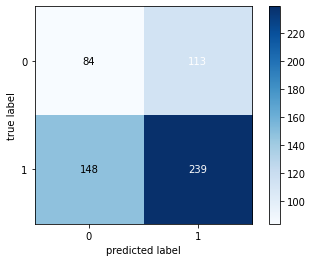

False Negative Rate 0.2534246575342466
error rate 0.4469178082191781


In [21]:
cf = confusion_matrix(y_test, y_predicted)
fig, ax = plot_confusion_matrix(conf_mat=cf, colorbar=True)
tn, fp, fn, tp = confusion_matrix(list(y_test), list(y_predicted), labels=[0, 1]).ravel()
tot = cf.sum()
tot = tn+tp+fp+fn
plt.show()
print('False Negative Rate', fn/tot)
print("error rate", (fn+fp)/tot)

In [22]:
from sklearn.metrics import fbeta_score
# 2.0 more weight to recall less to precision
print('fbeta 2')
print(fbeta_score(y_test, y_predicted, beta=2))

fbeta 2
0.6289473684210526


#ROC Curve

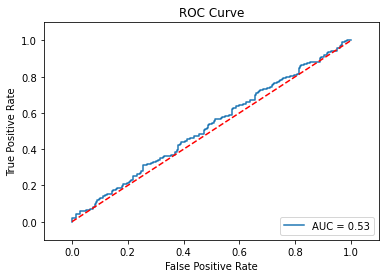

In [23]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
# take the second column because the classifier outputs scores for
# the 0 class as well
preds = y_probab[:,1]

# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = roc_curve(y_test, preds)

auc_score = auc(fpr, tpr)

# clear current figure
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

#PR Curve

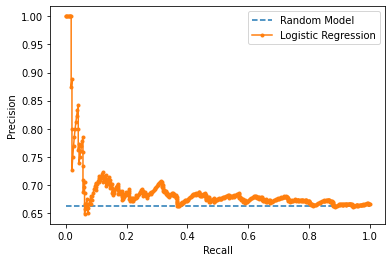

In [24]:
# PR curve for XGBoost regression model
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probab[:,1])
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='Random Model')
pyplot.plot(recall, precision, marker='.', label='Logistic Regression')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

# Export results

In [25]:
#df = pd.DataFrame({"Truth":y_test, "Pred":y_predicted, "Prob":y_probab[:,1]})

In [26]:
#df.to_csv("/content/drive/MyDrive/Thesis/MLAlgorithms/Logistic Regression/resultsLRDutch.csv")

In [27]:
#df